# Estimation of tree height using GEDI dataset - Perceptron complete - 2025

In [ ]:
'''
Packages

conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
conda install -c anaconda scikit-learn
conda install pandas
'''

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

In [ ]:
predictors = pd.read_csv("../tree_height/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


In [ ]:
# Filter heights below 7000
mask = predictors['h'] < 7000
predictors_under7k = predictors.loc[mask]

# Sample up to 100k rows (no replacement)
n = min(100000, len(predictors_under7k))
predictors_sel = predictors_under7k.sample(n, replace=False, random_state=0)

# Add height in meters at column index 4
predictors_sel.insert(4, 'hm', predictors_sel['h'] / 100)

# Row count
length_after = len(predictors_sel)
print('row count: {}'.format(length_after))

# Quick preview
head_preview = predictors_sel.head(10)


row count: 100000


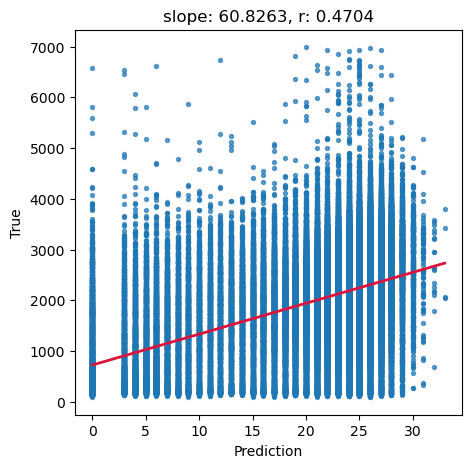

In [ ]:
# Ground truth and predictions
y_true = predictors_sel['h']
y_pred = predictors_sel['forestheight']

# Simple linear regression (y_true ~ y_pred)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_true)

# Scatter and annotation
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(y_pred, y_true, s=8, alpha=0.7)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r: {:.4f}'.format(slope, r_value))

# Optional: add fitted line
xline = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(xline, intercept + slope * xline, color='crimson', lw=2)

plt.show()

In [ ]:
# Target variable (meters) as NumPy array
tree_height = predictors_sel['hm'].to_numpy()

# Feature matrix without ID/targets/pred column
data = predictors_sel.drop(columns=['ID', 'h', 'hm', 'forestheight'], axis=1)


data.shape[1]: 20, n_plots_x: 5, n_plots_y: 4


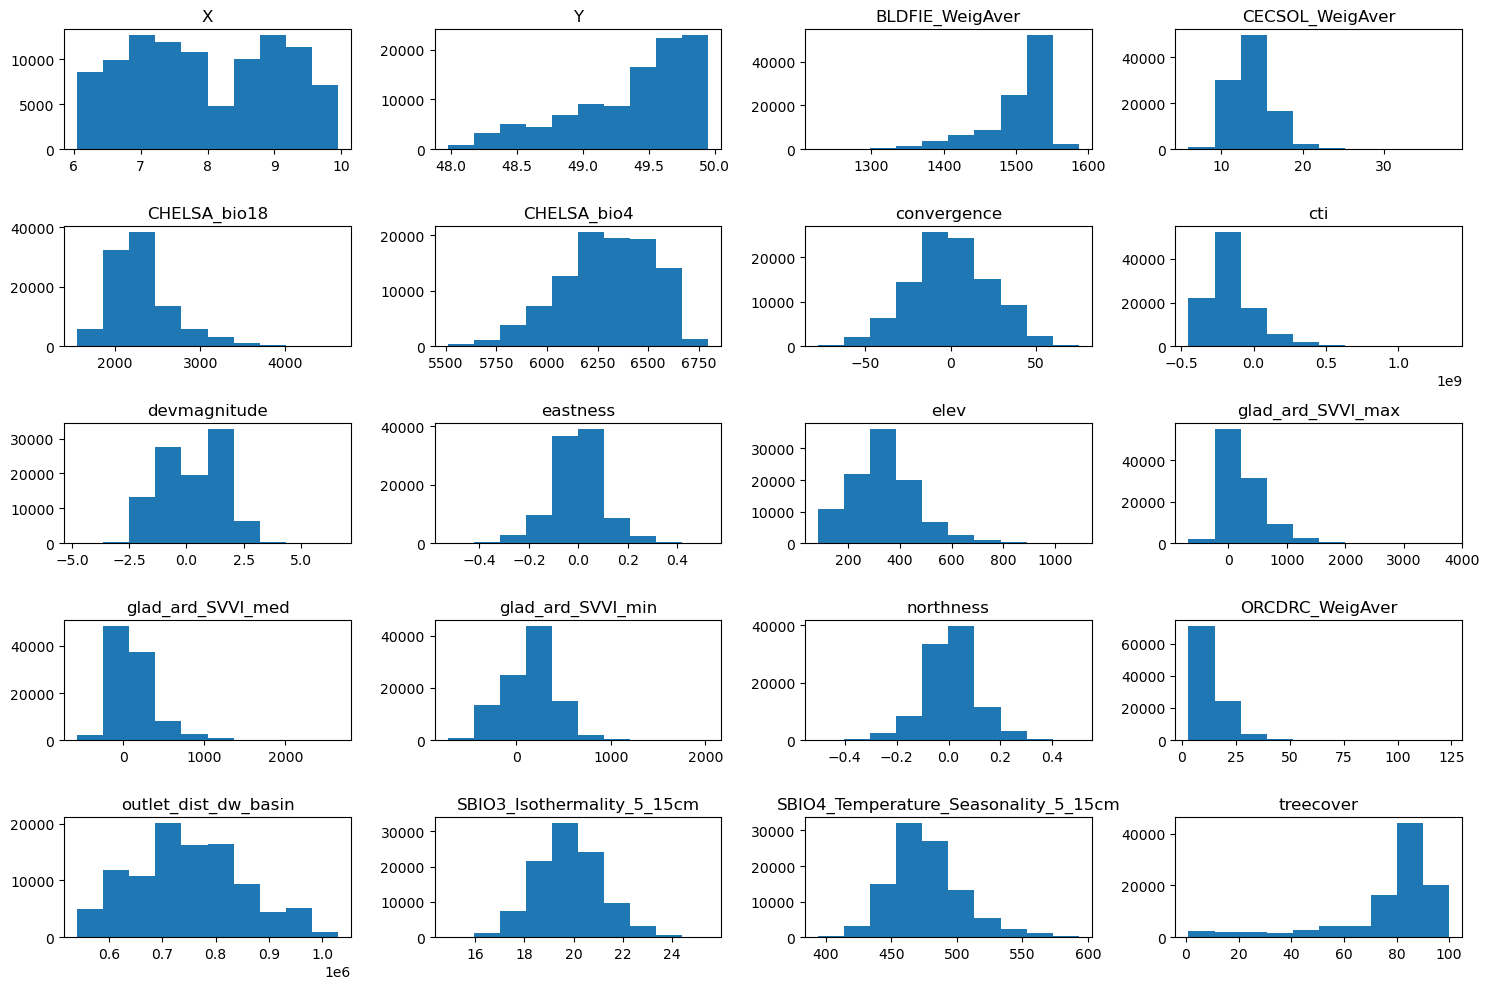

In [ ]:
# Grid size close to square
n_plots_x = int(np.ceil(np.sqrt(data.shape[1])))
n_plots_y = int(np.floor(np.sqrt(data.shape[1])))
print('data.shape[1]: {}, n_plots_x: {}, n_plots_y: {}'.format(data.shape[1], n_plots_x, n_plots_y))

# Subplots and flatten axes
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
ax = np.array(ax).ravel()  # handle when ax isn’t already 1D

# One histogram per feature
for idx in range(data.shape[1]):
    ax[idx].hist(data.iloc[:, idx].to_numpy().flatten())
    ax[idx].set_title(data.columns[idx])

# Tight layout
fig.tight_layout()


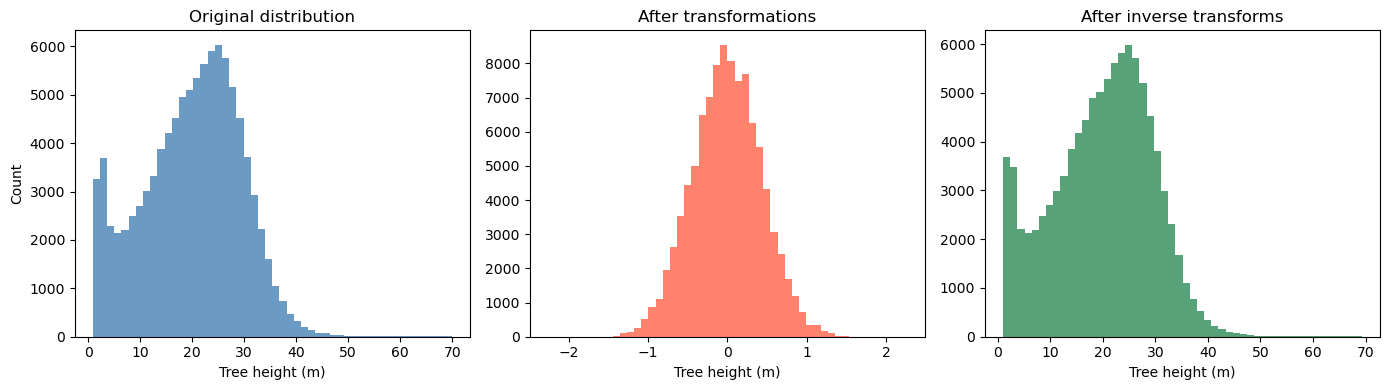

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

# Suppose tree_height_raw is your original 1D np.array
# Keep a copy for plotting the "before" distribution
x0 = tree_height.copy()

# 1) Fit and apply QuantileTransformer (to normal)
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=0)
x1 = qt.fit_transform(x0.reshape(-1, 1))  # shape (n, 1)

# 2) Fit and apply MinMaxScaler to [-1, 1]
scaler_tree = MinMaxScaler(feature_range=(-1, 1))
x2 = scaler_tree.fit_transform(x1)  # shape (n, 1)

# 3) Divide by 99th percentile (elementwise scaling)
q99 = np.quantile(x2.squeeze(), 0.99)
x3 = (x2.squeeze() / q99)  # shape (n,)

# Plot 1: before any transformation
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.hist(x0, bins=50, color="steelblue", alpha=0.8)
plt.title("Original distribution")
plt.xlabel("Tree height (m)")
plt.ylabel("Count")

# Plot 2: after all transformations (normalized)
plt.subplot(1,3,2)
plt.hist(x3, bins=50, color="tomato", alpha=0.8)
plt.title("After transformations")
plt.xlabel("Tree height (m)")

# ---- Inversion pipeline ----
# Inverse of step 3: multiply by q99, then reshape for scaler.inverse_transform
x2_rec = (x3 * q99).reshape(-1, 1)

# Inverse of step 2: MinMaxScaler inverse
x1_rec = scaler_tree.inverse_transform(x2_rec)  # shape (n, 1)

# Inverse of step 1: QuantileTransformer inverse
x0_rec = qt.inverse_transform(x1_rec).squeeze()  # shape (n,)

# Plot 3: after inverting all transformations
plt.subplot(1,3,3)
plt.hist(x0_rec, bins=50, color="seagreen", alpha=0.8)
plt.title("After inverse transforms")
plt.xlabel("Tree height (m)")
plt.tight_layout()
plt.show()


data.shape[1]: 20, n_plots_x: 5, n_plots_y: 4


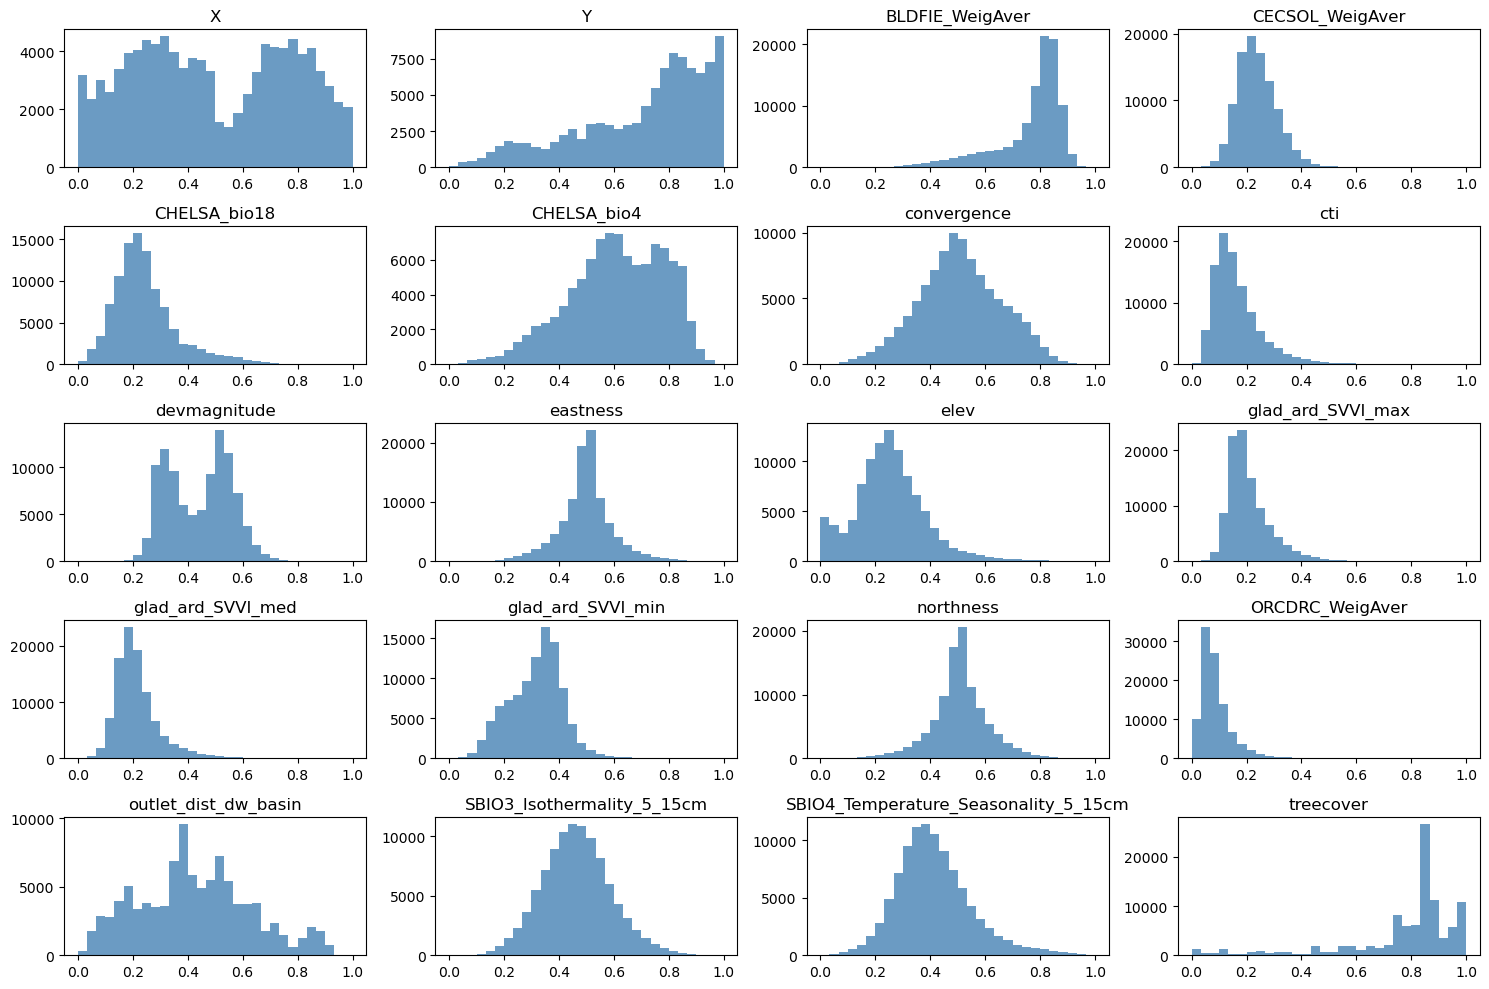

In [ ]:
# Normalize features to [0, 1]
scaler_data = MinMaxScaler()
data_transformed = scaler_data.fit_transform(data)

# Grid size (near-square)
n_plots_x = int(np.ceil(np.sqrt(data.shape[1])))
n_plots_y = int(np.floor(np.sqrt(data.shape[1])))
print('data.shape[1]: {}, n_plots_x: {}, n_plots_y: {}'.format(data.shape[1], n_plots_x, n_plots_y))

# Subplots and flat axes
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
ax = np.array(ax).ravel()

# Hist per feature (normalized)
for idx in range(data.shape[1]):
    ax[idx].hist(data_transformed[:, idx].ravel(), bins=30, color='steelblue', alpha=0.8)
    ax[idx].set_title(data.columns[idx])

# Layout
fig.tight_layout()


In [ ]:
# Let's use all the data as one big minibatch
tree_height = x3.copy() # We will the normalized tree_height

#Split the data
X_train, X_test, y_train, y_test = train_test_split(data_transformed,tree_height, test_size=0.30, random_state=0)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print('X_train.min: {}, X_test.min: {}, y_train.min: {}, y_test.min: {}'.format(X_train.min(), X_test.min(), y_train.min(), y_test.min()))
print('X_train.max: {}, X_test.max: {}, y_train.max: {}, y_test.max: {}'.format(X_train.max(), X_test.max(), y_train.max(), y_test.max()))

X_train.shape: torch.Size([70000, 20]), X_test.shape: torch.Size([30000, 20]), y_train.shape: torch.Size([70000]), y_test.shape: torch.Size([30000])
X_train.min: 0.0, X_test.min: 0.0, y_train.min: -2.261296272277832, y_test.min: -2.261296272277832
X_train.max: 1.0, X_test.max: 1.0, y_train.max: 2.261296272277832, y_test.max: 2.261296272277832


In [ ]:
# Create the model
class Perceptron(torch.nn.Module):
    def __init__(self,input_size, output_size,use_activation_fn=None):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size,output_size)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.use_activation_fn=use_activation_fn
    def forward(self, x):
        output = self.fc(x)
        if self.use_activation_fn=='sigmoid':
            output = self.sigmoid(output) # To add the non-linearity. Try training you Perceptron with and without the non-linearity
        elif self.use_activation_fn=='tanh':
            output = self.tanh(output)
        elif self.use_activation_fn=='relu':
            output = self.relu(output)

        return output


lr: 0.5
Epoch 0, train: 0.6429, val: 8.2494, r: -0.1007
Epoch 500, train: nan, val: nan, r: nan
Epoch 1000, train: nan, val: nan, r: nan
Epoch 1500, train: nan, val: nan, r: nan
Epoch 2000, train: nan, val: nan, r: nan
Epoch 2500, train: nan, val: nan, r: nan
Epoch 3000, train: nan, val: nan, r: nan
Epoch 3500, train: nan, val: nan, r: nan
Epoch 4000, train: nan, val: nan, r: nan
Epoch 4500, train: nan, val: nan, r: nan


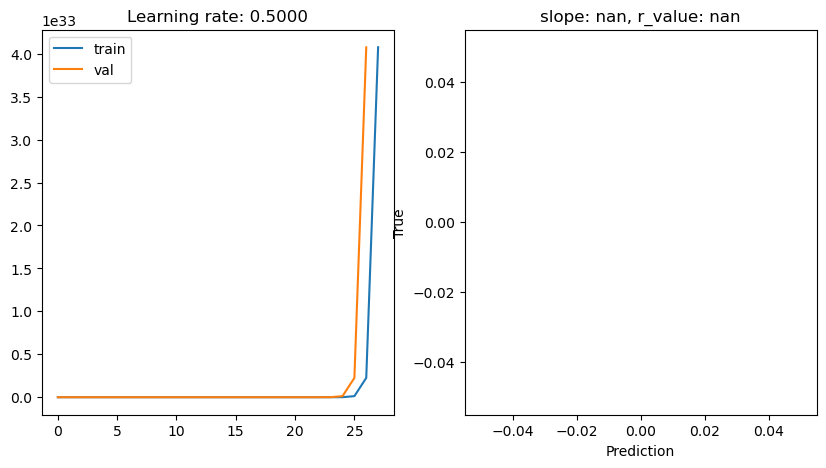


lr: 0.1
Epoch 0, train: 0.2114, val: 0.2048, r: -0.0597
Epoch 500, train: 0.1527, val: 0.1555, r: 0.4249
Epoch 1000, train: 0.1517, val: 0.1546, r: 0.4309
Epoch 1500, train: 0.1513, val: 0.1541, r: 0.4334
Epoch 2000, train: 0.1511, val: 0.1539, r: 0.4347
Epoch 2500, train: 0.1510, val: 0.1538, r: 0.4355
Epoch 3000, train: 0.1509, val: 0.1537, r: 0.4361
Epoch 3500, train: 0.1508, val: 0.1536, r: 0.4365
Epoch 4000, train: 0.1507, val: 0.1536, r: 0.4368
Epoch 4500, train: 0.1507, val: 0.1535, r: 0.4371


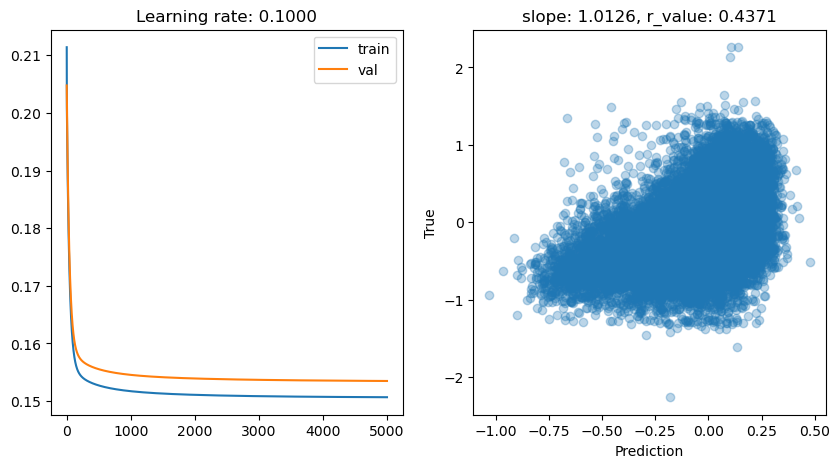


lr: 0.05
Epoch 0, train: 0.2027, val: 0.2031, r: -0.1429
Epoch 500, train: 0.1537, val: 0.1564, r: 0.4206
Epoch 1000, train: 0.1524, val: 0.1551, r: 0.4274
Epoch 1500, train: 0.1518, val: 0.1546, r: 0.4306
Epoch 2000, train: 0.1515, val: 0.1543, r: 0.4325
Epoch 2500, train: 0.1513, val: 0.1541, r: 0.4337
Epoch 3000, train: 0.1511, val: 0.1539, r: 0.4346
Epoch 3500, train: 0.1510, val: 0.1538, r: 0.4352
Epoch 4000, train: 0.1509, val: 0.1538, r: 0.4357
Epoch 4500, train: 0.1509, val: 0.1537, r: 0.4360


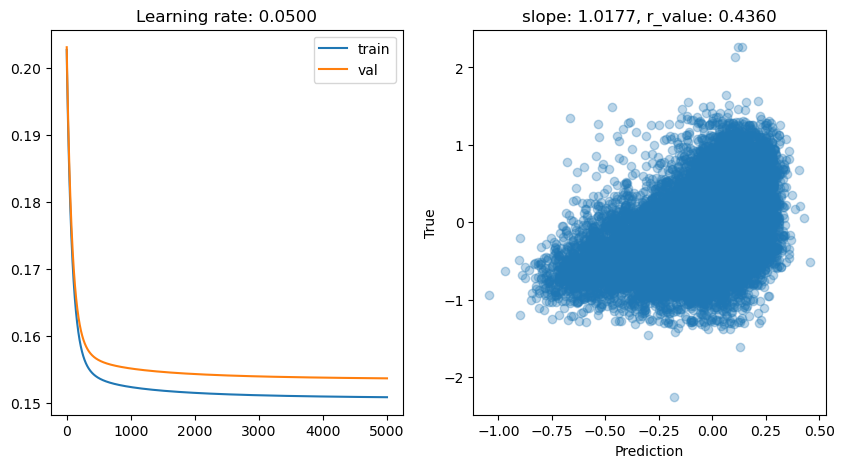


lr: 0.01
Epoch 0, train: 0.3875, val: 0.3572, r: -0.2029
Epoch 500, train: 0.1706, val: 0.1732, r: 0.3439
Epoch 1000, train: 0.1600, val: 0.1627, r: 0.4002
Epoch 1500, train: 0.1563, val: 0.1591, r: 0.4105
Epoch 2000, train: 0.1548, val: 0.1576, r: 0.4154
Epoch 2500, train: 0.1540, val: 0.1568, r: 0.4186
Epoch 3000, train: 0.1535, val: 0.1563, r: 0.4209
Epoch 3500, train: 0.1531, val: 0.1560, r: 0.4226
Epoch 4000, train: 0.1529, val: 0.1557, r: 0.4241
Epoch 4500, train: 0.1527, val: 0.1555, r: 0.4253


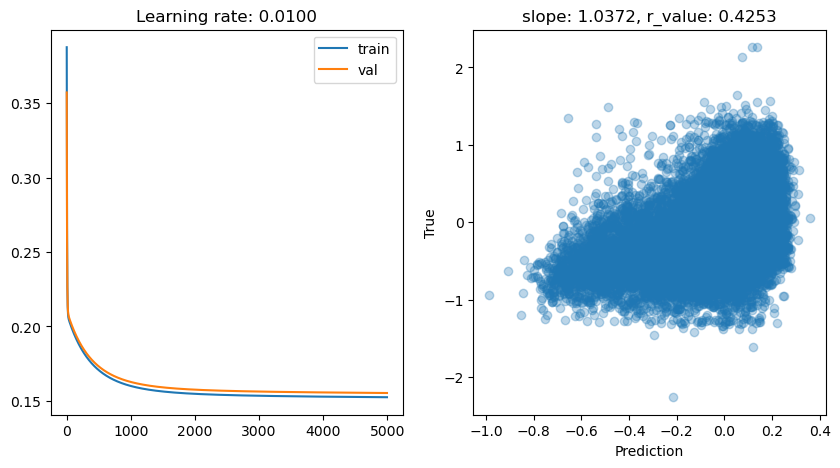


lr: 0.001
Epoch 0, train: 0.2326, val: 0.2318, r: -0.1197
Epoch 500, train: 0.1907, val: 0.1924, r: -0.0472
Epoch 1000, train: 0.1867, val: 0.1885, r: 0.0821
Epoch 1500, train: 0.1832, val: 0.1850, r: 0.1937
Epoch 2000, train: 0.1800, val: 0.1820, r: 0.2704
Epoch 2500, train: 0.1773, val: 0.1793, r: 0.3182
Epoch 3000, train: 0.1748, val: 0.1769, r: 0.3476
Epoch 3500, train: 0.1726, val: 0.1747, r: 0.3663
Epoch 4000, train: 0.1706, val: 0.1728, r: 0.3786
Epoch 4500, train: 0.1689, val: 0.1711, r: 0.3870


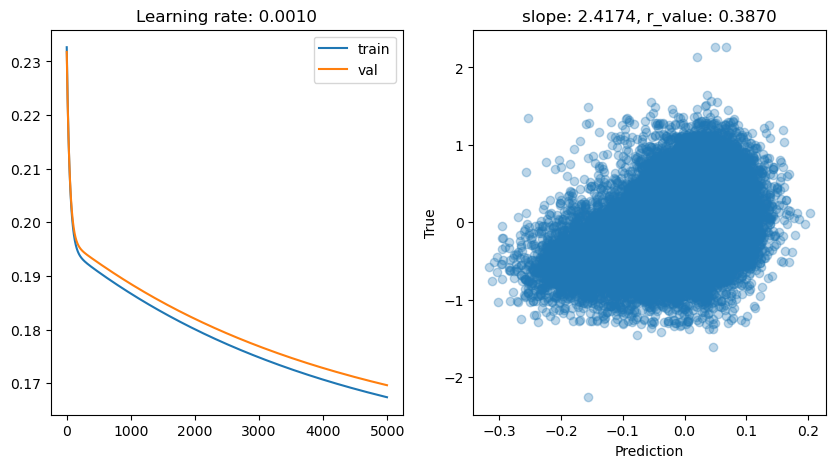

In [ ]:
# Hyperparameters
epoch = 5000
out_size = 1
lr_range = [0.5, 0.1, 0.05, 0.01, 0.001]  # learning rates

for lr in lr_range:
    print('\nlr: {}'.format(lr))

    # Fresh model/optimizer each run
    if 'model' in globals():
        del model, criterion, optimizer

    # Model, loss, optimizer. Notice that no non-linear activation is being used
    model = Perceptron(data.shape[1], out_size)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    all_loss_train = []
    all_loss_val = []

    for epoch in range(epoch):
        # Train step
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        all_loss_train.append(loss.item())

        # Val step
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_test)
            val_loss = criterion(y_pred_val.squeeze(), y_test)
            all_loss_val.append(val_loss.item())

            # Periodic metrics
            if epoch % 500 == 0:
                y_np = y_pred_val.detach().cpu().numpy().squeeze()
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                    y_np, y_test.cpu().numpy().squeeze()
                )
                print('Epoch {}, train: {:.4f}, val: {:.4f}, r: {:.4f}'
                        .format(epoch, all_loss_train[-1], all_loss_val[-1], r_value))

    # Plot losses and final scatter
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(all_loss_train, label='train')
    ax[0].plot(all_loss_val, label='val')
    ax[0].set_title('Learning rate: {:.4f}'.format(lr))
    ax[0].legend()

    ax[1].scatter(y_np, y_test.cpu().numpy().squeeze(), alpha=0.3)
    ax[1].set_xlabel('Prediction')
    ax[1].set_ylabel('True')
    ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
    plt.show()


Let's see the effect of adding a non-linear activation


lr: 0.5
Epoch 0, train: 0.1975, val: 0.3391, r: 0.0630
Epoch 500, train: 0.2624, val: 0.4150, r: 0.4285
Epoch 1000, train: 0.2656, val: 0.4176, r: 0.4323
Epoch 1500, train: 0.2698, val: 0.4221, r: 0.4336
Epoch 2000, train: 0.2723, val: 0.4248, r: 0.4344
Epoch 2500, train: 0.2739, val: 0.4263, r: 0.4349
Epoch 3000, train: 0.2750, val: 0.4272, r: 0.4353
Epoch 3500, train: 0.2758, val: 0.4280, r: 0.4356
Epoch 4000, train: 0.2766, val: 0.4287, r: 0.4359
Epoch 4500, train: 0.2772, val: 0.4293, r: 0.4361


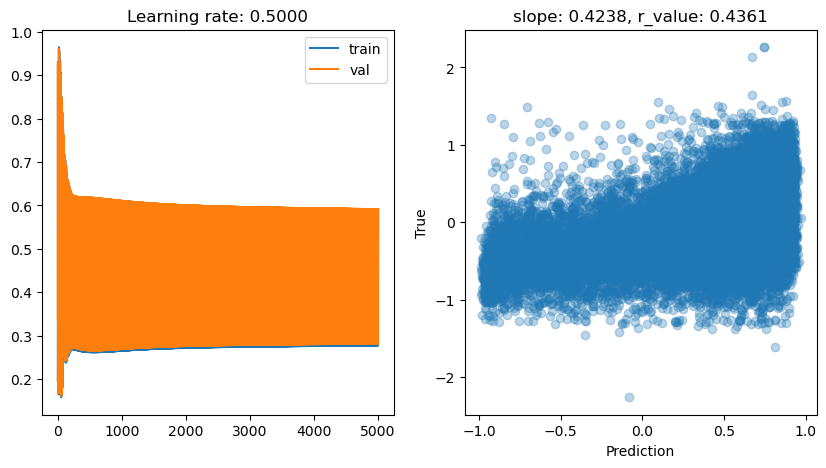


lr: 0.1
Epoch 0, train: 0.2231, val: 0.1906, r: 0.0445
Epoch 500, train: 0.1520, val: 0.1550, r: 0.4282
Epoch 1000, train: 0.1513, val: 0.1543, r: 0.4326
Epoch 1500, train: 0.1509, val: 0.1539, r: 0.4348
Epoch 2000, train: 0.1507, val: 0.1537, r: 0.4362
Epoch 2500, train: 0.1506, val: 0.1535, r: 0.4372
Epoch 3000, train: 0.1505, val: 0.1534, r: 0.4378
Epoch 3500, train: 0.1504, val: 0.1533, r: 0.4383
Epoch 4000, train: 0.1503, val: 0.1532, r: 0.4387
Epoch 4500, train: 0.1503, val: 0.1532, r: 0.4390


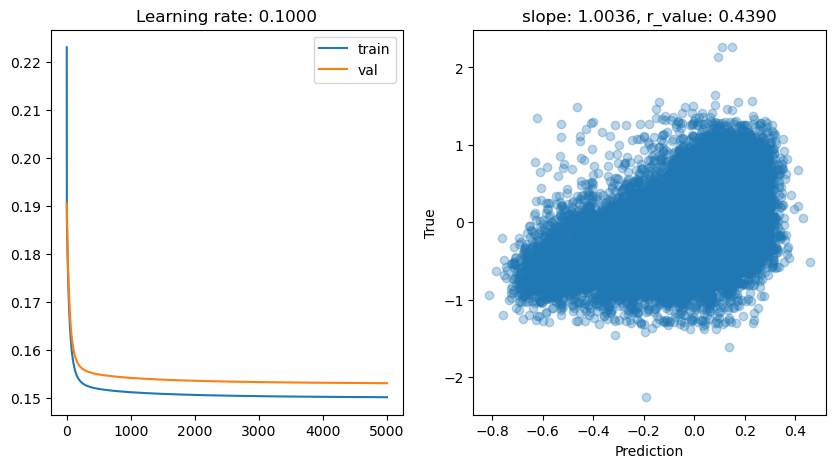


lr: 0.01
Epoch 0, train: 0.3765, val: 0.3505, r: 0.1727
Epoch 500, train: 0.1656, val: 0.1683, r: 0.3561
Epoch 1000, train: 0.1590, val: 0.1618, r: 0.3960
Epoch 1500, train: 0.1563, val: 0.1591, r: 0.4077
Epoch 2000, train: 0.1550, val: 0.1578, r: 0.4133
Epoch 2500, train: 0.1542, val: 0.1570, r: 0.4169
Epoch 3000, train: 0.1536, val: 0.1565, r: 0.4195
Epoch 3500, train: 0.1533, val: 0.1561, r: 0.4214
Epoch 4000, train: 0.1530, val: 0.1559, r: 0.4231
Epoch 4500, train: 0.1527, val: 0.1556, r: 0.4244


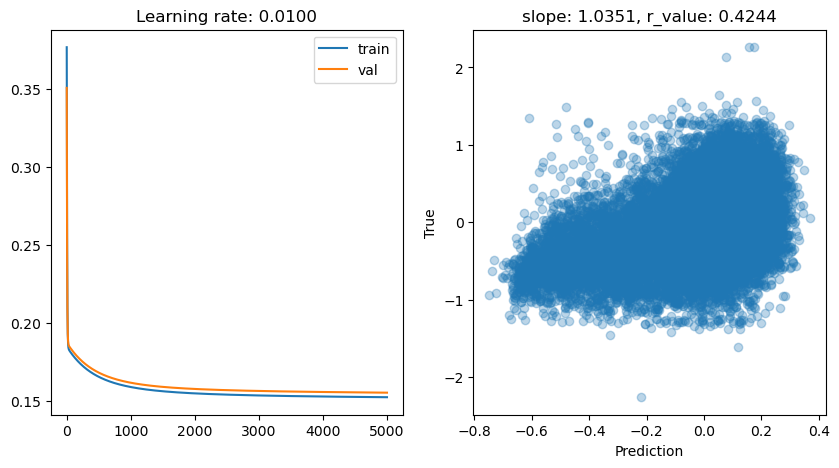


lr: 0.05
Epoch 0, train: 0.2363, val: 0.2242, r: -0.2098
Epoch 500, train: 0.1546, val: 0.1573, r: 0.4165
Epoch 1000, train: 0.1528, val: 0.1556, r: 0.4245
Epoch 1500, train: 0.1521, val: 0.1550, r: 0.4283
Epoch 2000, train: 0.1517, val: 0.1546, r: 0.4307
Epoch 2500, train: 0.1514, val: 0.1543, r: 0.4322
Epoch 3000, train: 0.1512, val: 0.1541, r: 0.4333
Epoch 3500, train: 0.1511, val: 0.1540, r: 0.4342
Epoch 4000, train: 0.1509, val: 0.1539, r: 0.4349
Epoch 4500, train: 0.1509, val: 0.1538, r: 0.4354


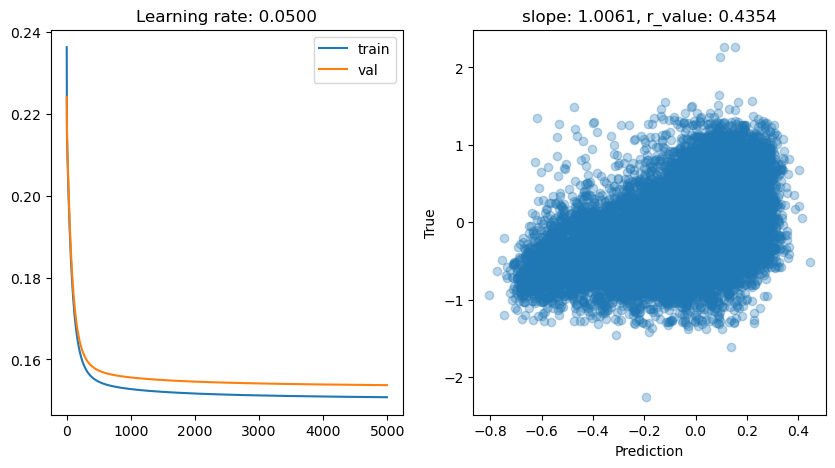


lr: 0.001
Epoch 0, train: 0.2269, val: 0.2298, r: 0.1256
Epoch 500, train: 0.1841, val: 0.1871, r: 0.1775
Epoch 1000, train: 0.1802, val: 0.1833, r: 0.2058
Epoch 1500, train: 0.1769, val: 0.1800, r: 0.2329
Epoch 2000, train: 0.1741, val: 0.1772, r: 0.2582
Epoch 2500, train: 0.1717, val: 0.1748, r: 0.2811
Epoch 3000, train: 0.1696, val: 0.1727, r: 0.3015
Epoch 3500, train: 0.1678, val: 0.1709, r: 0.3191
Epoch 4000, train: 0.1662, val: 0.1694, r: 0.3340
Epoch 4500, train: 0.1648, val: 0.1680, r: 0.3466


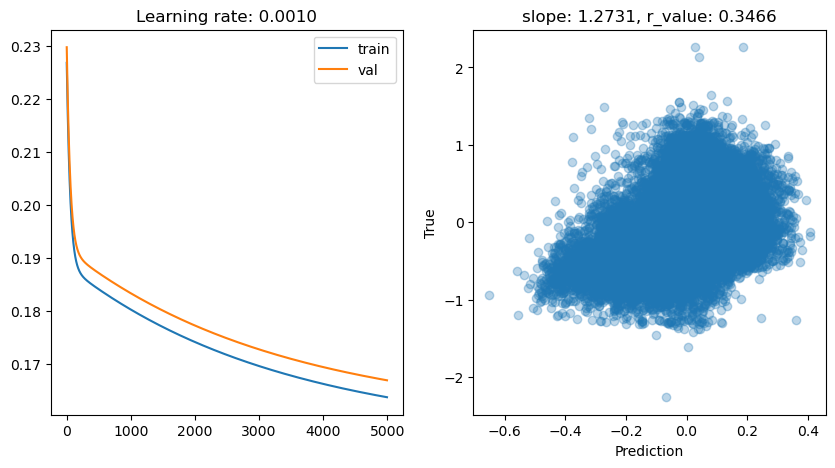

In [ ]:
# Hyperparams
epoch = 5000
out_size = 1
lr_range = [0.5, 0.1, 0.01, 0.05, 0.001]

for lr in lr_range:
    print('\nlr: {}'.format(lr))

    # Reset model/optimizer each run
    if 'model' in globals():
        del model, criterion, optimizer

    # Model with tanh activation, MSE loss, SGD optimizer
    model = Perceptron(data.shape[1], out_size, use_activation_fn='tanh')
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    all_loss_train = []
    all_loss_val = []

    for epoch in range(epoch):
        # Train
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train.squeeze(), y_train)
        loss_train.backward()
        optimizer.step()
        all_loss_train.append(loss_train.item())

        # Validate
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_test)
            loss_val = criterion(y_pred_val.squeeze(), y_test)
            all_loss_val.append(loss_val.item())

            # Periodic metrics/log
            if epoch % 500 == 0:
                y_np = y_pred_val.detach().cpu().numpy().squeeze()
                r_true = y_test.detach().cpu().numpy().squeeze()
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_np, r_true)
                print('Epoch {}, train: {:.4f}, val: {:.4f}, r: {:.4f}'
                      .format(epoch, all_loss_train[-1], all_loss_val[-1], r_value))

    # Plots: losses and final scatter
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(all_loss_train, label='train')
    ax[0].plot(all_loss_val, label='val')
    ax[0].set_title('Learning rate: {:.4f}'.format(lr))
    ax[0].legend()

    ax[1].scatter(y_np, r_true, alpha=0.3)
    ax[1].set_xlabel('Prediction')
    ax[1].set_ylabel('True')
    ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
    plt.show()


TanH works nicely. Would sigmoid or relu do well too? Try it!

We have tested SGD extensively. Now let's see what other optimizers have to offer (BACK TO SLIDES)


lr: 0.5
Epoch 0, train: 0.1966, val: 21.2664, r: -0.0081
Epoch 500, train: 0.1506, val: 0.1534, r: 0.4378
Epoch 1000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 1500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 2000, train: 0.9653, val: 0.9759, r: 0.4176
Epoch 2500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 3000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 3500, train: 0.1549, val: 0.1540, r: 0.4382
Epoch 4000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 4500, train: 0.1506, val: 0.1533, r: 0.4382


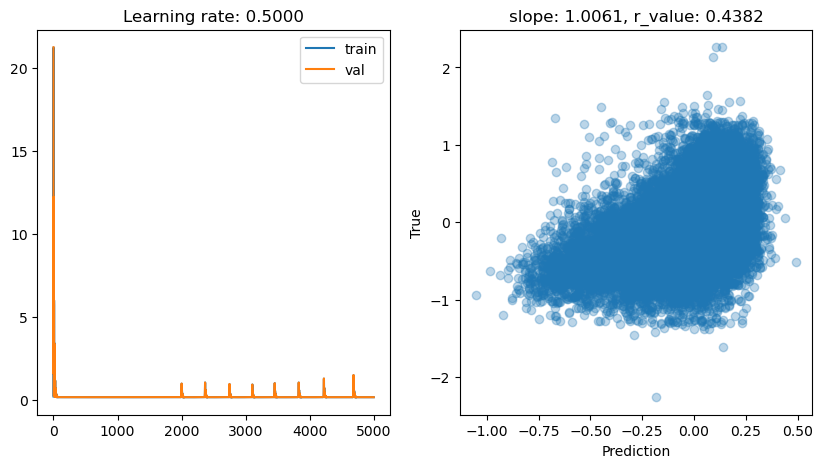


lr: 0.1
Epoch 0, train: 0.2058, val: 0.4035, r: 0.1423
Epoch 500, train: 0.1506, val: 0.1534, r: 0.4380
Epoch 1000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 1500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 2000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 2500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 3000, train: 0.1506, val: 0.1534, r: 0.4382
Epoch 3500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 4000, train: 0.1508, val: 0.1534, r: 0.4383
Epoch 4500, train: 0.1506, val: 0.1533, r: 0.4382


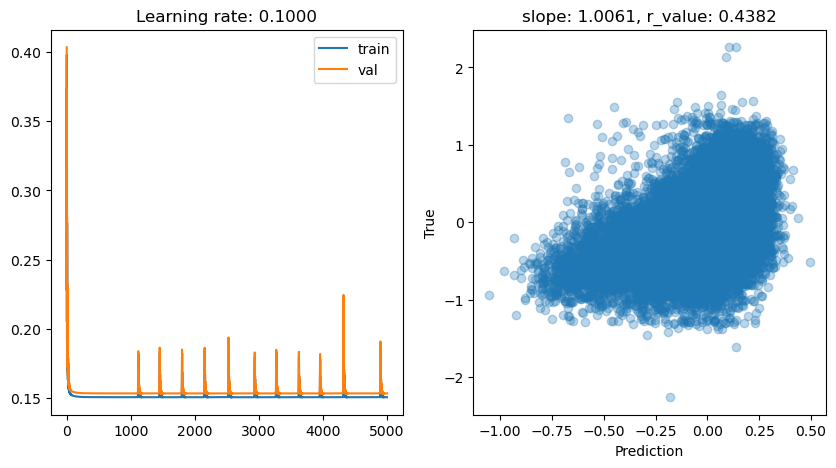


lr: 0.05
Epoch 0, train: 0.2726, val: 0.2291, r: 0.0207
Epoch 500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 1000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 1500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 2000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 2500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 3000, train: 0.1584, val: 0.1600, r: 0.4382
Epoch 3500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 4000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 4500, train: 0.1506, val: 0.1533, r: 0.4382


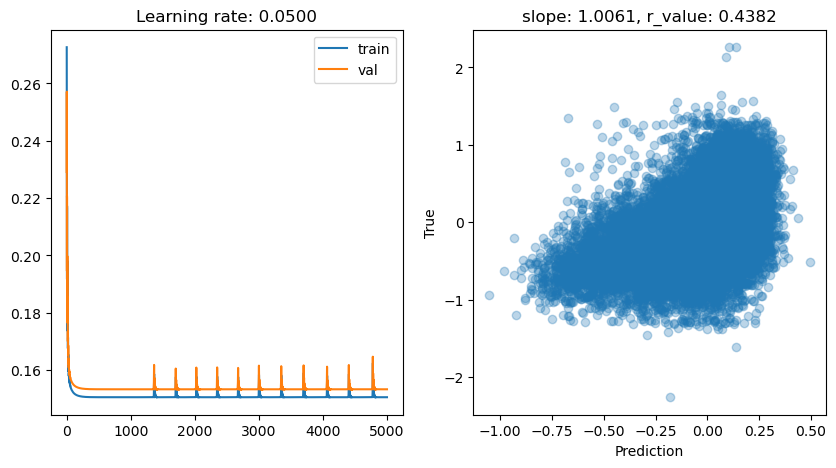


lr: 0.01
Epoch 0, train: 0.2532, val: 0.2187, r: -0.0238
Epoch 500, train: 0.1510, val: 0.1538, r: 0.4356
Epoch 1000, train: 0.1507, val: 0.1534, r: 0.4377
Epoch 1500, train: 0.1506, val: 0.1534, r: 0.4381
Epoch 2000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 2500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 3000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 3500, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 4000, train: 0.1506, val: 0.1533, r: 0.4382
Epoch 4500, train: 0.1506, val: 0.1533, r: 0.4382


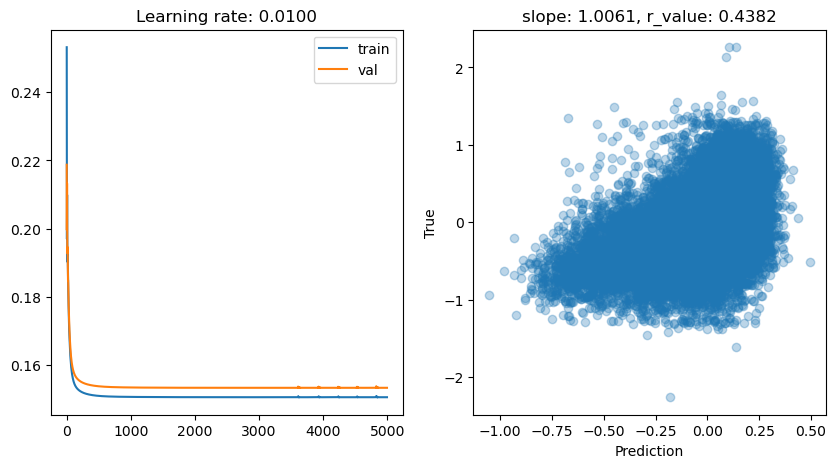


lr: 0.001
Epoch 0, train: 0.4179, val: 0.4153, r: -0.0727
Epoch 500, train: 0.1734, val: 0.1764, r: 0.2786
Epoch 1000, train: 0.1597, val: 0.1628, r: 0.3857
Epoch 1500, train: 0.1546, val: 0.1576, r: 0.4145
Epoch 2000, train: 0.1525, val: 0.1554, r: 0.4266
Epoch 2500, train: 0.1515, val: 0.1544, r: 0.4321
Epoch 3000, train: 0.1511, val: 0.1539, r: 0.4349
Epoch 3500, train: 0.1508, val: 0.1537, r: 0.4364
Epoch 4000, train: 0.1507, val: 0.1535, r: 0.4372
Epoch 4500, train: 0.1507, val: 0.1534, r: 0.4377


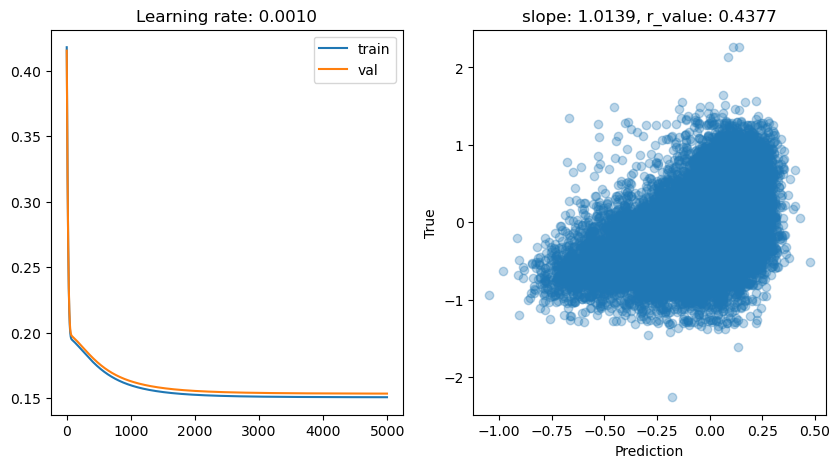

In [ ]:
# Try Adam optimizer
epoch = 5000
out_size = 1
lr_range = [0.5, 0.1, 0.05, 0.01, 0.001]

for lr in lr_range:
    print('\nlr: {}'.format(lr))

    # Fresh model/optimizer each run
    if 'model' in globals():
        del model, criterion, optimizer

    # Model, loss, optimizer (Adam)
    model = Perceptron(data.shape[1], out_size)  # or use_activation_fn='tanh' if supported
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    all_loss_train = []
    all_loss_val = []

    for epoch in range(epoch):
        # Train
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train.squeeze(), y_train)
        loss_train.backward()
        optimizer.step()
        all_loss_train.append(loss_train.item())

        # Validate
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_test)
            loss_val = criterion(y_pred_val.squeeze(), y_test)
            all_loss_val.append(loss_val.item())

            # Periodic log/metric
            if epoch % 500 == 0:
                y_np = y_pred_val.detach().cpu().numpy().squeeze()
                y_true_np = y_test.detach().cpu().numpy().squeeze()
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_np, y_true_np)
                print('Epoch {}, train: {:.4f}, val: {:.4f}, r: {:.4f}'
                      .format(epoch, all_loss_train[-1], all_loss_val[-1], r_value))

    # Plots: losses and final scatter
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(all_loss_train, label='train')
    ax[0].plot(all_loss_val, label='val')
    ax[0].set_title('Learning rate: {:.4f}'.format(lr))
    ax[0].legend()

    ax[1].scatter(y_np, y_true_np, alpha=0.3)
    ax[1].set_xlabel('Prediction')
    ax[1].set_ylabel('True')
    ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
    plt.show()


ADAM seems to be quite effective for training in this setup if compared to other tests we did. How is it performing compared to the SVR? How can we make it better?  